# BeyondLLM Framework: Different Approach to RAG and its Evaluation
We decided to include this notebook on our project to give other perpectives on evaluating RAG models. The framework explored is **BeyondLLM** and this notebook is an adaptation of the tutorial found [here](https://colab.research.google.com/drive/1vf9ebWWmZDn6vP9uqy-Zgzt8RSUSV-1o?usp=sharing&source=post_page-----c3cd710a6357--------------------------------). It is recommended to run this notebook on a new environment.

## Build - Rapid Experiment - Evaluate - Repeat

Beyond LLM is a comprehensive framework for developing, testing, and evaluating Retrieval-Augmented Generation (RAG) systems. It streamlines the process with automated integration, customizable evaluation metrics, and support for various Large Language Models (LLMs) designed to meet specific requirements of the user. The goal is to minimize the risk of hallucinations in LLMs and improve their overall reliability.

### Useful Links:
- [Documentation](https://beyondllm.aiplanet.com/)
- [Github Repo](https://github.com/aiplanethub/beyondllm)

## Install the packages

Make sure to **restart session** after installing the packages.

In [ ]:
! pip install beyondllm llama_index.embeddings.huggingface

## Overview

In this notebook, we'll develop a RAG pipeline, which helps us chat with YouTube video using BeyondLLM (and evaluating its performance). The code includes:

- Getting data from source
- Creating embeddings
- Retrieving documents
- Generating LLM responses
- Evaluating responses

In [2]:
import os
import Constants
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = Constants.LANGCHAIN_API_KEY

In [3]:
HFHUB_API_KEY = Constants.HFHUB_API_KEY

## Import BeyondLLM

In [ ]:
from beyondllm import source,retrieve,embeddings,llms,generator

## Fit the Data

In [5]:
data = source.fit(
    path="../Data/TA-9-2024-0138_EN.pdf", 
    dtype="pdf",
    chunk_size=512,     
    chunk_overlap=128   
)

## Embedding Model

The embedding model we are using here will be the "BAAI/bge-small-en-v1.5" model from HuggingFace Hub. This is an open-source embedding model.

Here's the [link](https://huggingface.co/BAAI/bge-small-en-v1.5) to the HuggingFace Hub repo of the model.

In [6]:
model_name='BAAI/bge-small-en-v1.5'

embed_model = embeddings.HuggingFaceEmbeddings(
    model_name=model_name
)

## Define the Retriever

Here we are using the "cross-rerank" type of retriever.

You can look into the types of retrievers that BeyondLLM has to offer [here](https://beyondllm.aiplanet.com/core-components/auto-retriever).

In [7]:
retriever = retrieve.auto_retriever(
    data=data,
    embed_model=embed_model,
    type="cross-rerank",
    mode="OR",
    top_k=2)

## LLM

Initialize the Large Language Model, that will be used to generate the responses to our questions.

In this case we will use the "mistralai/Mistral-7B-Instruct-v0.2" model.

To use the model, access the [repository](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3), login with your **HuggingFace account** and **agree to share your contact information to access this model** <br><br>
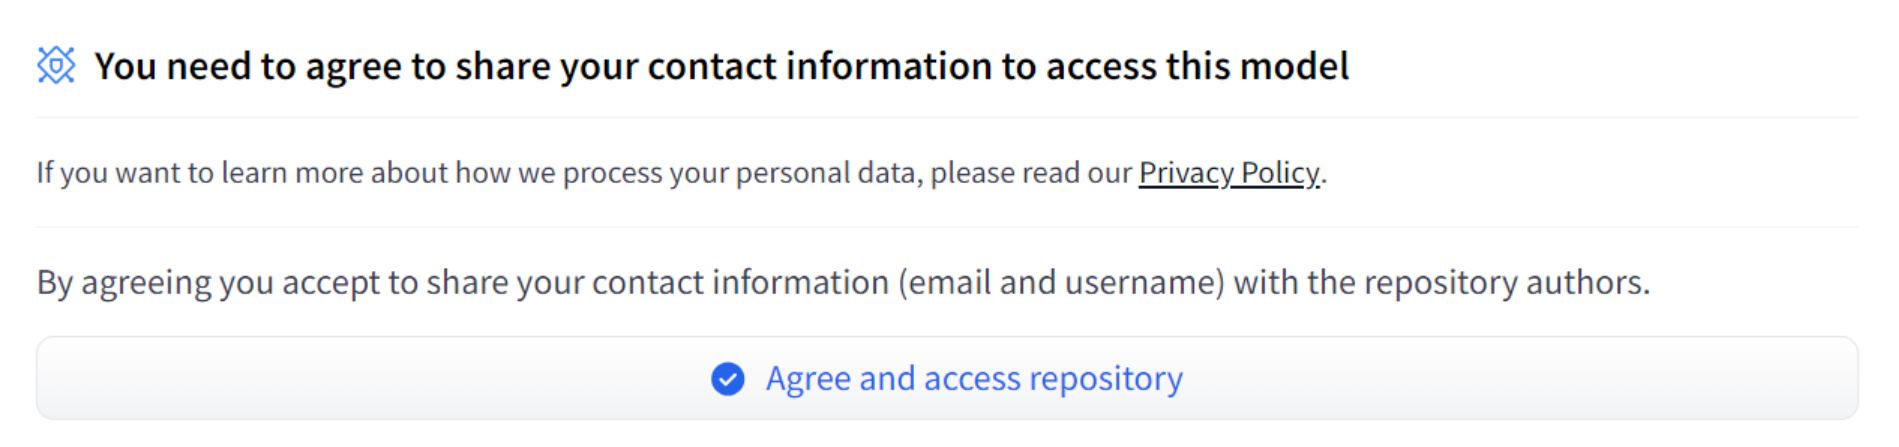

In [9]:
llm = llms.HuggingFaceHubModel(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=HFHUB_API_KEY
)

## Define the Prompt and questions

In the cell below, we define the system prompt and the questions to the LLM. The system prompt is required for open-source LLMs like the "mistralai/Mistral-7B-Instruct-v0.2".

In [10]:
questions = [
    "What is the primary purpose of the AI Act?",
    "How does the AI Act categorize high-risk AI applications?",
    "What are the transparency requirements for high-risk AI systems under the AI Act?",
    "How does the AI Act impact AI providers from outside the EU?",
    "What measures does the AI Act require to ensure human oversight in AI systems?",
]


system_prompt = f"""
<s>[INST]
You are an AI Assistant.
Please provide direct answers to questions.
[/INST]
</s>
"""

In [11]:
# Define a function to process multiple questions
def process_questions(questions, retriever, system_prompt, llm, max_length=80):
    results = []
    
    for question in questions:
        # Generate response for each question
        pipeline = generator.Generate(
            question=question,
            retriever=retriever,
            system_prompt=system_prompt,
            llm=llm
        )
        
        # Execute the pipeline and collect results
        response = pipeline.call()
        evaluations = pipeline.get_rag_triad_evals()
        
        # Store the response and evaluations
        results.append({
            'question': question,
            'response': response,
            'evaluations': evaluations
        })
    
    return results



## Evaluate RAG

In [12]:
import textwrap
# Example usage
# Replace with your actual questions
results = process_questions(questions, retriever, system_prompt, llm)

# Print results with text wrapping
for result in results:
    print(f"Question: {result['question']}")
    print('\n')
    print(textwrap.fill(result['response'], width=100)) 
    print('\n')
    print(f"Evaluations:")
    print(result['evaluations'])
    print("\n-----------------------\n") 


Executing RAG Triad Evaluations...
Executing RAG Triad Evaluations...
Executing RAG Triad Evaluations...
Executing RAG Triad Evaluations...
Executing RAG Triad Evaluations...
Question: What is the primary purpose of the AI Act?


         ANSWER: The primary purpose of the AI Act is to improve the functioning of the internal
market and promote the uptake of human-centric and trustworthy artificial intelligence (AI) in the
European Union (EU), while ensuring a high level of protection of health, safety, fundamental
rights, including democracy, the rule of law and environmental protection, against the harmful
effects of AI systems in the EU. It also supports innovation.


Evaluations:
Context relevancy Score: 5.5
This response does not meet the evaluation threshold. Consider refining the structure and content for better clarity and effectiveness.
Answer relevancy Score: 10.0
This response meets the evaluation threshold. It demonstrates strong comprehension and coherence.
Groundness score

- Overall, the performance is very satisfactory